# Summary

## Actions
* Created a variable for when a security deposit is required
* Bundled misc property types in 'other' category
* Created new features based on the amenities text field
* Removed 'zipcode', 'availability_60', 'availability_90', 'bed_type', 'host_has_profile_pic', 'requires_license'
* One-hot-encoded all categorical features
* Imputed all missing values with the median value
* Completed K-means clustering to identify groupings of listings that may help modeling
* Log transformed the price target

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Actions" data-toc-modified-id="Actions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Actions</a></span></li></ul></li><li><span><a href="#Create-Variables" data-toc-modified-id="Create-Variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Variables</a></span></li><li><span><a href="#Category-Encoding" data-toc-modified-id="Category-Encoding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Category Encoding</a></span></li><li><span><a href="#Imputing" data-toc-modified-id="Imputing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Imputing</a></span></li><li><span><a href="#Target-Transformation" data-toc-modified-id="Target-Transformation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Target Transformation</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li><li><span><a href="#Save" data-toc-modified-id="Save-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save</a></span></li></ul></div>

In [1]:
# Import needed libraries
#from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
sns.set() 

plt.style.use('fivethirtyeight')

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_pickle('data/processed/listings_cleaned.pkl')

In [2]:
df.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,requires_license,instant_bookable,cancellation_policy,reviews_per_month,Topic,median_home_value,median_income,population,distance_Disneyland,distance_Universal,distance_Convention_Center,distance_LAX,distance_Downtown_LA,distance_Seaworld,distance_Santa_Monica_beach,distance_San_Diego,distance_Venice_beach,distance_Griffith_Park,distance_Hollywood,distance_Long_beach,distance_Ontario_airport,distance_Compton,distance_Rose_Bowl
0,within an hour,100.0,True,1.0,True,False,93550,34.485432,-118.125381,House,Private room,2,1.0,1.0,1.0,Real Bed,{},50.0,NaN,0.0,1,0.0,1,1125,29,45,75,350,33,93.0,f,False,flexible,1.91,6,278000,20222,75774,47.831340,27.240032,31.757775,40.730427,30.827716,129.380985,39.019592,134.346325,39.960522,27.162750,29.146583,49.875594,42.246084,40.869533,22.082232
1,within an hour,100.0,True,2.0,True,True,93550,34.556740,-118.063812,House,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",32.0,NaN,10.0,1,5.0,1,1125,1,19,48,48,22,92.0,f,True,flexible,4.89,5,278000,20222,75774,51.928789,33.245785,37.478527,46.656835,36.517031,132.558790,45.058054,137.440999,45.971478,33.060207,35.105072,55.010913,43.570516,46.291467,27.506948
2,within an hour,100.0,True,2.0,True,True,93550,34.560383,-118.097412,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Kitchen,""Free parking on premises"",""Smoking a...",24.0,NaN,0.0,1,8.0,1,1125,20,46,76,351,50,95.0,f,False,moderate,2.76,8,278000,20222,75774,52.516787,32.556593,37.161992,46.108002,36.228216,133.507963,44.231833,138.417538,45.259948,32.555840,34.510018,55.112044,44.965477,46.209716,27.409527
3,within a few hours,90.0,False,1.0,True,True,93550,34.557838,-118.084343,Apartment,Entire home/apt,4,2.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",95.0,$150.00,0.0,1,0.0,6,150,19,21,21,272,12,96.0,f,False,flexible,0.38,1,278000,20222,75774,52.203890,32.744202,37.198973,46.241453,36.253740,133.064145,44.479491,137.963696,45.460138,32.667396,34.659456,54.987096,44.357639,46.155240,27.354661
4,NaN,0.0,True,1.0,True,True,93550,34.576488,-118.082581,House,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air conditio...",50.0,NaN,0.0,1,15.0,1,3,0,0,0,0,15,97.0,f,False,moderate,1.09,4,278000,20222,75774,53.450689,33.929663,38.460595,47.460506,37.519105,134.219215,45.620846,139.109282,46.637485,33.897307,35.868944,56.276564,45.302083,47.439612,28.638536


In [3]:
X = df.drop(columns=['price'],axis=1)
y = df.price

# Create Variables

In [4]:
# Create security_deposit_required boolean feature then drop security_deposit column
list_sec = df['security_deposit']
sd = []
for row in list_sec:
    if pd.isnull(row):
        sd.append(0.0)
    else:
        sd.append(1.0)
df['security_deposit_required'] = sd
df = df.drop('security_deposit',axis=1)

In [5]:
main_types = ['Apartment', 'House', 'Condominium',
              'Townhouse', 'Loft', 'Guesthouse','']

cat_rename = []

for l in list(df.property_type.unique()):
    if l not in main_types:
        cat_rename.append(l)

updated = []        
for i,prop in enumerate(df['property_type']):
    if prop in cat_rename:
        updated.append('Other')        
     
    else:
        updated.append(prop)

df['property_type_cleaned'] = updated

In [6]:
# Derive new features from the text field 'amenities'
ame = df.amenities.astype('object')
ame_list = ('Internet', 'Wireless', 'Kitchen', 'Free parking',
            'Air conditioning', 'TV', 'Pets', 'Heating', 'Washer', 'Family',
            'Smoking allowed','Dryer','Family/kid','Pets allowed','Gym','Self Check-In')

for am in (ame_list):
    df[am] = ame.str.contains(am)

df = df.drop('amenities', axis=1)

In [7]:
df = df.drop(columns=['availability_60', 'availability_90', 'bed_type', 'host_has_profile_pic', 
                      'availability_365'], axis=1)

# Category Encoding

In [8]:
# Turn categorical into column features
features = ['host_response_time','property_type_cleaned','room_type','cancellation_policy']
df = pd.get_dummies(df,columns=features,drop_first=True, dtype='bool')

In [9]:
df['Topic'] = df['Topic'].astype('category')
df = pd.get_dummies(df,columns=['Topic'], dtype='bool', prefix='lda_topic', drop_first=True)

# Imputing

In [10]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [11]:
missing = missing_values_table(df)

Your selected dataframe has 83 columns and 20586 rows.
There are 6 columns that have missing values.


In [12]:
# Impute missing instances with the median
for col in missing.index:
    try:
        df[col] = df[col].fillna(df[col].median())
    except:
        pass

# Target Transformation

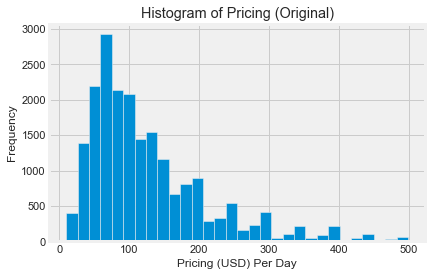

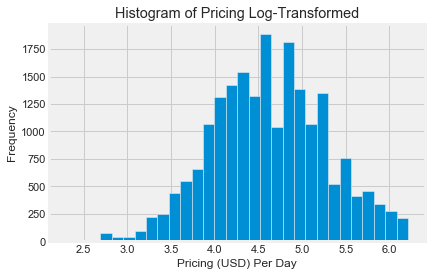

In [13]:
# log transform the response 'price'
df['price_log'] = df['price'].apply(lambda x: math.log(x))

# visualize distribution of price (target variable)
plt.hist(df['price'], bins=30)
plt.title("Histogram of Pricing (Original)")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.savefig('original_price.png', orientation='landscape', pad_inches=.1, bbox_inches='tight')
plt.show()

# visualize distribution of price (target variable)
plt.hist(df['price_log'], bins=30)
plt.title("Histogram of Pricing Log-Transformed")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.savefig('transformed_price.png', orientation='landscape', pad_inches=.1, bbox_inches='tight')
plt.show()

## Clustering

In [14]:
from sklearn.cluster import KMeans

clust = df[[
    'price_log', 'median_income', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'cleaning_fee', 'population', 'median_home_value'
]]

km = KMeans(n_clusters=6,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=1234)
km.fit_predict(clust)
y_km = km.fit_predict(clust)

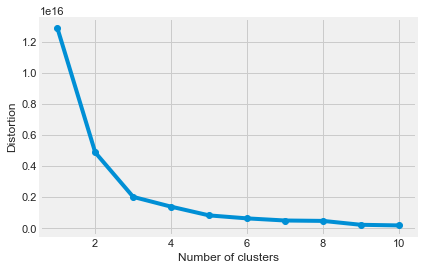

In [15]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(clust)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

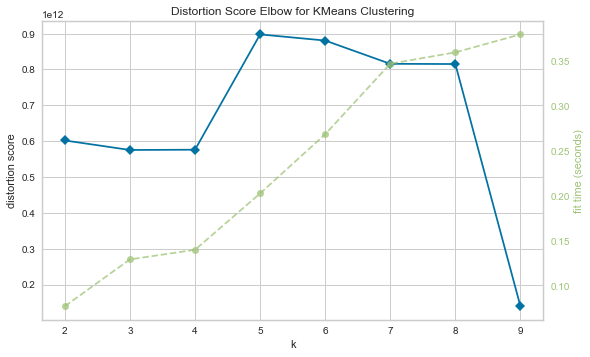

In [16]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(clust)        # Fit the data to the visualizer
visualizer.finalize()        # Finalize and render the figure

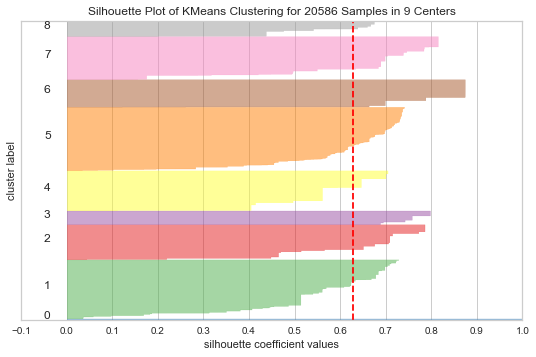

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(clust)        # Fit the data to the visualizer
visualizer.finalize()        # Finalize and render the figure

C:\Users\peril\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


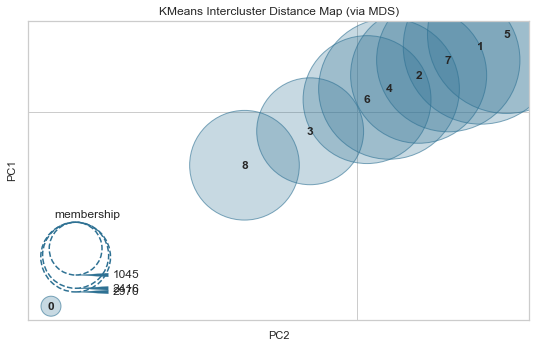

In [18]:
from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(km)

visualizer.fit(clust)        # Fit the data to the visualizer
visualizer.finalize()        # Finalize and render the figure

In [19]:
clust = df[[
    'price_log', 'median_income', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'cleaning_fee', 'population', 'median_home_value'
]]


km = KMeans(
    n_clusters=9, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=1234
)
km.fit_predict(clust)
y_km = km.fit_predict(clust)

df['clustered_location'] = km.labels_
df = df.drop(columns=['zipcode','property_type'],axis=1)

C:\Users\peril\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


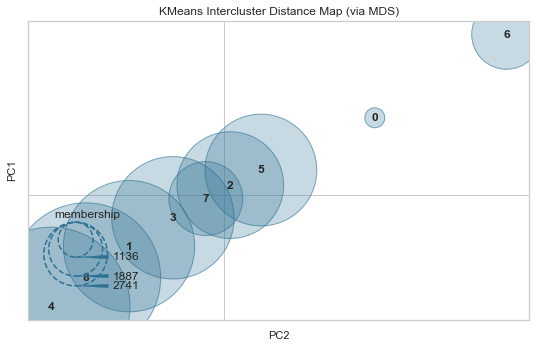

In [20]:
visualizer = InterclusterDistance(km)

visualizer.fit(clust)        # Fit the data to the visualizer
visualizer.finalize()   

In [21]:
df = pd.get_dummies(df,columns=['clustered_location'],drop_first=True, dtype='bool')

# Save

In [22]:
df.to_pickle('data/processed/listings_cleaned_processed.pkl')

In [23]:
df.head()

,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,number_of_reviews,review_scores_rating,requires_license,instant_bookable,reviews_per_month,median_home_value,median_income,population,distance_Disneyland,distance_Universal,distance_Convention_Center,distance_LAX,distance_Downtown_LA,distance_Seaworld,distance_Santa_Monica_beach,distance_San_Diego,distance_Venice_beach,distance_Griffith_Park,distance_Hollywood,distance_Long_beach,distance_Ontario_airport,distance_Compton,distance_Rose_Bowl,security_deposit_required,Internet,Wireless,Kitchen,Free parking,Air conditioning,TV,Pets,Heating,Washer,Family,Smoking allowed,Dryer,Family/kid,Pets allowed,Gym,Self Check-In,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,property_type_cleaned_Condominium,property_type_cleaned_Guesthouse,property_type_cleaned_House,property_type_cleaned_Loft,property_type_cleaned_Other,property_type_cleaned_Townhouse,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,lda_topic_2,lda_topic_3,lda_topic_4,lda_topic_5,lda_topic_6,lda_topic_7,lda_topic_8,lda_topic_9,lda_topic_10,price_log,clustered_location_1,clustered_location_2,clustered_location_3,clustered_location_4,clustered_location_5,clustered_location_6,clustered_location_7,clustered_location_8
0,100.0,True,1.0,False,34.485432,-118.125381,2,1.0,1.0,1.0,50.0,0.0,1,0.0,1,1125,29,33,93.0,f,False,1.91,278000,20222,75774,47.831340,27.240032,31.757775,40.730427,30.827716,129.380985,39.019592,134.346325,39.960522,27.162750,29.146583,49.875594,42.246084,40.869533,22.082232,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,3.912023,False,False,False,True,False,False,False,False
1,100.0,True,2.0,True,34.556740,-118.063812,2,1.5,1.0,1.0,32.0,10.0,1,5.0,1,1125,1,22,92.0,f,True,4.89,278000,20222,75774,51.928789,33.245785,37.478527,46.656835,36.517031,132.558790,45.058054,137.440999,45.971478,33.060207,35.105072,55.010913,43.570516,46.291467,27.506948,0.0,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,3.465736,False,False,False,True,False,False,False,False
2,100.0,True,2.0,True,34.560383,-118.097412,2,1.0,1.0,1.0,24.0,0.0,1,8.0,1,1125,20,50,95.0,f,False,2.76,278000,20222,75774,52.516787,32.556593,37.161992,46.108002,36.228216,133.507963,44.231833,138.417538,45.259948,32.555840,34.510018,55.112044,44.965477,46.209716,27.409527,0.0,False,False,True,True,False,False,False,False,True,True,True,True,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,3.178054,False,False,False,True,False,False,False,False
3,90.0,False,1.0,True,34.557838,-118.084343,4,2.0,2.0,3.0,95.0,0.0,1,0.0,6,150,19,12,96.0,f,False,0.38,278000,20222,75774,52.203890,32.744202,37.198973,46.241453,36.253740,133.064145,44.479491,137.963696,45.460138,32.667396,34.659456,54.987096,44.357639,46.155240,27.354661,1.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4.553877,False,False,False,True,False,False,False,False
4,0.0,True,1.0,True,34.576488,-118.082581,2,1.5,1.0,1.0,50.0,0.0,1,15.0,1,3,0,15,97.0,f,False,1.09,278000,20222,75774,53.450689,33.929663,38.460595,47.4